
# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint


## Learning Objectives 

At the end of the experiment, you will be able to:

1.   Generate text which is similar to the writing style of William Shakespeare
2.   Understand how to adapt or tune the trained network

In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/module_3_week_12_experiment_1.mp4" type="video/mp4">
</video>
""")

## Dataset


###  Description

The dataset used in this experiment has partial content of different plays of Shakespeare concatenated into a single plain text file. 

Shakespeare is a famous English poet , play writer and actor. He is regarded as the greatest writer in the English language and the world's greatest dramatist. He is often called a England's national poet and the Bard of Avon. 

We have chosen plays of Shakespeare as our dataset mainly for two reasons : 

1. His work is widely recognized as standard for poetry and language.
2. The result of combining of his work provides a sizeable corpus for our model to learn.

The plays of Shakespeare are taken from the following url:

www.opensourceshakespeare.org/views/plays/plays.php


## Domain Information

Music and Art are considered creative in nature and creating them is assumed to be more difficult when compared to writing a book, article or text. But the reality is that creating music and art is less complicated because there are no strict rules like which direction should one paint in or when to pause between the notes. However,  while writing a text one must follow grammatical rules. Hence, writing/generating text task is more related to machine learning and artificial intelligence.





## AI/ML Technique 



The RNN algorithm is used to generate text which is similar to the writing style of Shakespeare. Let us try to understand the main idea behind using this algorithm.

### RNN algorithm

The main idea is to use sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a bad idea. If you want to predict the next word in a sentence you better know which words came before it. This is possible through RNN. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. 

*Example:*  Take an example string **“HELLO”**. The vocabulary of the example is made of four letters or characters H,E,L,O. Now, let us apply RNN algorithm on this.

Give *'H'* as input to the trained RNN model, it would give us an output *'E'*. In the next stage, this output *'E'* is passed as the new input which would give us the new output *'L'*. As the cycle follows, this output *'L'* is the new input but then what do you think the new output should be, second *‘L’* or *‘O’*? This is the challenge in predicting the next letter or character which RNN can solve. RNN has its own memory which helps it to predict based on the previous characters in this case H, E and L. Hence the output would most probably be *'L'* and not *'O'*.  

![alt text](https://cdn.talentsprint.com/aiml/Experiment_related_data/IMAGES/7.1.png)

In this experiment we will follow below steps:

1.   Preparing the data
2.   Building the model
3.   Defining helper functions
4.   Training the model
5.    Adapting or Fine-tuning for text generation




In [ ]:
! wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week10/Exp1/shakespeare.txt


### Importing required packages


In [ ]:
import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable

import time, math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### 1. Preparing the Data

The file here is a plain text file. By using the [unidecode](https://pypi.org/project/Unidecode/) package turn any potential unicode characters into plain ASCII

In [ ]:
# Code to extract all sets of punctuation, digits, ascii_letters and whitespace characters
all_characters = string.printable

# Code to find length of all_characters and storing the value in n_characters
n_characters = len(all_characters)

# Use unidecode to convert unicode characters into plain ASCII
file = unidecode.unidecode(open('shakespeare.txt').read())

# Code to find length of the file
file_len = len(file)

# Printing the length of the file
print('file_len =', file_len)

file_len = 1115393


The variable 'file' is a string with 1115393 characters. This is the raw content of the Shakespeare text file (dataset file), including many details like white spaces, line breaks etc. 

Now to get the sense of the data we print first 1000 characters in the string:

In [ ]:
file[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

As the string is large, split it into chunks to provide inputs to the RNN using the function random_chunk()

In [ ]:
# Initialization of the chunk length for the number of RNN's in a particular length, so that it can recall up to 200 timesteps backwards.
chunk_len = 200

# Function to split the string into chunks
def random_chunk():
    
    # Initializing the starting index value of the big string 
    start_index = random.randint(0, file_len - chunk_len)

    # Initializing the ending index of the string 
    end_index = start_index + chunk_len + 1

    # Returning the chunk
    return file[start_index:end_index]

# Printing the random chunk string
print(random_chunk())

he market-place. We'll attend you there:
Where, if you bring not Marcius, we'll proceed
In our first way.

MENENIUS:
I'll bring him to you.
Let me desire your company: he must come,
Or what is worst wi


###  2. Building the Model

This model will take input as the character for step $t_{-1}$, and is expected to give the output $t$, which is the next character. There are three layers:
1. Linear layer that encodes the input character into an internal state
2. GRU layer (which may itself have multiple layers) that operates on that internal and hidden state / You can also use the [RNN](https://pytorch.org/docs/master/generated/torch.nn.RNN.html) Layer in place of GRU in this step.
3. Decoder layer that outputs the probability distribution

In [ ]:
# Creating recurrent neural network
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers) # If you want to use RNN you can replace GRU with RNN and see the results
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden) # Change self.gru to self.rnn if you are constructing the RNN layer
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        # Here we are Initializing the hidden layer to zero everytime
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

### 3. Defining the Helper Functions

Let us define some helper functions to:

1. Convert the input string chunks into the character tensors
2. Evaluate the model

#### Inputs and Targets
Each chunk will be turned into a tensor, specifically a LongTensor (used for integer values), by looping through the characters of the string and looking up the index of each character in all_characters.

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

# Let us print the tensor value for a given sample string, you can modify the string here...
print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally you assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the end, and the target will be all characters from the first. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

#### Evaluating

To evaluate the network feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation pass a priming string to start building up the hidden state, from which you then generate one character at a time.

In the below function let us assign the default primary string as 'A' and to choose a class with a probability output use the [muiltinomial distribution](https://pytorch.org/docs/master/generated/torch.multinomial.html)

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp, hidden)
        
        # Applying Softmax & Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

### 4. Training the Model

To keep track of how long training takes, let us add a time_since(timestamp) function which returns a human readable string:

In [ ]:
# Function to print amount of time passed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### The main training function

In [ ]:
def train(inp, target):
    # Initialize the hidden representation, gradient, loss to zeros
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = rnn(inp[c], hidden)
        '''unsqueeze() is used to add dimension to the tensor'''
        loss += criterion(output, target[c].unsqueeze(dim=0))
    # Back propagation
    loss.backward()
    rnn_optimizer.step()

    return loss.item() / chunk_len

Then define the training parameters, instantiate the model, and start training. In the below cell  try to print the chunk, loss and time taken for every 50th iteration and for every 20th iteration  try to plot the loss vs epochs(iterations).

In [ ]:
n_epochs = 2000 # Number of epochs
print_every = 50
plot_every = 20
hidden_size = 100
n_layers = 1
lr = 0.005

# The input_size & output_size are the total number of n_characters
rnn = RNN(n_characters, hidden_size, n_characters, n_layers) # The rnn variable consists of the return values from the RNN model

# Optimize
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

# Loss function
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 6s (50 2%) 2.3858]
Wh goos bes't thtie wist obe bor poto Kerendy haf lon, anth; sor,
I thee nos the pereit?
KAENENNYwor t 

 13s (100 5%) 2.1937]
Whalk the th, if pay thand, his the seint ath the hec gin sto the to thin gored shos lathe for bounegs 

 19s (150 7%) 2.2499]
Whe wend ard word her breree rovast ord to to he in
Rom and, cess be aresou sterer, worst cour you jor 

 26s (200 10%) 1.9275]
Wher.

ROINCENTETISCETIR:
Eo mery tho gom this led me busthand of you with ont the mout me whis arth s 

 32s (250 12%) 2.0821]
Whave morviold not to lo gerarser heindds you son:
Yith'h to mO heve worsse to you ladd som'an my sere 

 39s (300 15%) 2.2278]
Whire, uspine the his fakerels's bet his not bret are leest for eodagent, uampend, would gund, al shal 

 45s (350 17%) 1.9701]
Whery gray, gome a to may his ar dore.
As may, hy my an coud-many! 
Nook bood well we mank ast will yo 

 52s (400 20%) 2.0703]
Whill and hercine!

GEROM:
That in you fathere frorge
The mave and the saderome the in

#### Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

Text(0, 0.5, 'loss')

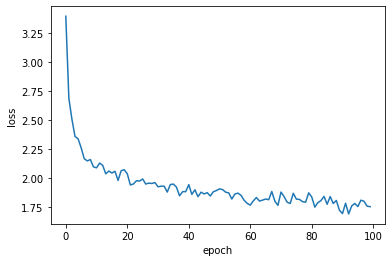

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.xlabel("epoch")
plt.ylabel("loss")

### 5. Adapting or Tuning for Text Generation

In the evaluate function above, every time a prediction is made, the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. By turning the temperature towards zero you are choosing only the most likely outputs.

Let us see the effects of this by adjusting the temperature argument:

In [ ]:
print(evaluate('u', 200, temperature=0.8))

umpher
for the sweecelmom pitter, hebed what be gone
we pant that it not in the bededast, I their
gentle a wat wat sword ay not his good thou have stale
me me litdence they not how save to stoniter fro


Lower temperatures are less varied, choosing only the more probable outputs:

In [ ]:
print(evaluate('Th', 200, temperature=0.2))

The show the forth
go the stand the stand the stand the forth the stand
I will the conclieve his stand a stands a site and the stand
I will this should the stand he so the stand
I shall the stand the st



Higher temperatures more varied, choosing less probable outputs:

In [ ]:
print(evaluate('how', 200, temperature=1.4))

how.
My trult be is I hemstion,
Egesnany woy't. uto, toiciso. Werrothpronks
soll, tty hust waid kighartno, him me: i!
But then not bo'
Well
this pauke Fatracky, takeoande! a bontin,
I' knot, nob'X\iod ba


### Ungraded Exercise 1:

Change the number of epochs to 1000. Calculate the time taken and loss

In [ ]:
# YOUR CODE HERE

### Acknowledgement

https://blog.owulveryck.info/2017/10/29/about-recurrent-neural-network-shakespeare-and-go.html